Wir betrachten den Diabetes-Datensatz (`sklearn.datasets.load_diabets`) mit kontinuierlicher Zielgröße "target", der in VL05 besprochen wurde. Splitten Sie den Datensatz in Trainings- und Validierungsdaten.

### Teilaufgabe 1
Trainieren Sie einen (Regressions-)Entscheidungsbaum und wählen Sie den Hyperparameter `max_depth`, so dass die Performance-Metrik (s.u.) auf den Validierungsdaten optimal ist.

Wie viele verschiedene Werte kommen in den Predictions vor?

<Axes: xlabel='max_depth'>

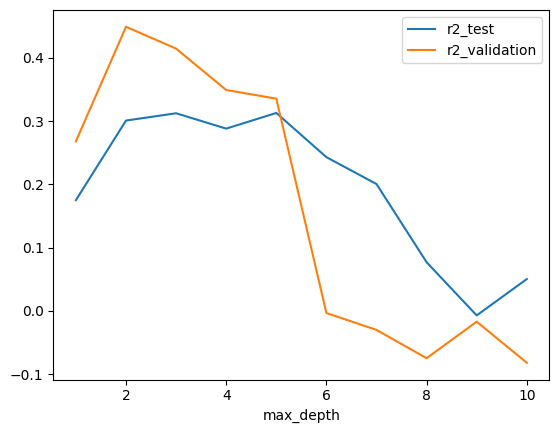

In [96]:
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.datasets import load_diabetes
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import r2_score
X,y = load_diabetes(as_frame=True, return_X_y=True)

X_train, X_rest, y_train, y_rest = train_test_split(X,y, train_size=0.6, random_state=42)
X_validation, X_test, y_validation, y_test = train_test_split(X_rest,y_rest, train_size=0.5, random_state=42)

metrics = []
for max_depth in range(1, 11):
	reg = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
	reg.fit(X_train, y_train)
	metrics.append({
		"r2_test": r2_score(y_test, reg.predict(X_test)),
		"r2_validation": r2_score(y_validation, reg.predict(X_validation)),
		"max_depth": max_depth
	})
df_metrics = pd.DataFrame(metrics)
df_metrics
df_metrics.plot(y=["r2_test", "r2_validation"], x="max_depth")

### Teilaufgabe 2
Der im Schritt 1 gewählte Hyperparameter `max_depth` wird im folgenden festgehalten. Es sei nun `N=100` ein weiterer Parameter.

Trainieren Sie nun `N` mal auf den Trainingsdaten einen Entscheidungsbaum trainieren, um `N` Bäume zu erhalten.

Damit diese Bäume nicht identisch sind, soll jedes Training auf einer zufälligen Teilmenge der Trainingsdaten erfolgen; hierzu soll n-mal "mit Zurücklegen" aus den Trainingsdaten gezogen werden, wenn der Trainingsdatensatz die Größe n hat.

(Hinweis: Verwenden Sie hierfür für ein pandas Dataframe `df.sample(frac=1.0, replace=True)`.),
und zusätzlich der Hyperparameter `max_features=5` gesetzt werden, wodurch bei jedem Split nur 5 zufällig ausgewählte Features in Betracht gezogen werden.


In [97]:

trees = []
for N in range(1,101):
	df_sampled = pd.concat([X_train, y_train], axis=1).sample(frac=0.8)
	X_sampled = df_sampled.iloc[:,:-1]
	y_sampled = df_sampled.iloc[:,-1]
	reg = DecisionTreeRegressor(max_depth=7, max_features=5, random_state=42)
	reg.fit(X_train, y_train)
	trees.append(reg)

### Teilaufgabe 3
Erstellen Sie nun ein "Ensemble-Modell", in dem die Predictions aus allen N Bäumen gemittelt werden. Welche Performance ergibt sich auf den Validierungsdaten? Wie viele Werte nehmen die Predictions jeweils an?

In [98]:
class Ensemble:
	def __init__(self, X_train, y_train, n_trees=100, max_depth=7):
		self.trees = []
		for N in range(1,n_trees+1):
			df_train_sampled = pd.concat([X_train, y_train], axis=1).sample(frac=0.8)
			X_train_sampled = df_train_sampled.iloc[:,:-1]
			y__train_sampled = df_train_sampled.iloc[:,-1]
			reg = DecisionTreeRegressor(max_depth=max_depth, max_features=5, random_state=42)
			reg.fit(X_train_sampled, y__train_sampled)
			self.trees.append(reg)

	def predict_ensemble(self, X):
		predictions = np.zeros((X.shape[0], len(self.trees)))
		for i, tree in enumerate(self.trees):
			predictions[:,i] = tree.predict(X)
		return predictions.mean(axis=1)

ensemble = Ensemble(X_train, y_train, n_trees=100, max_depth=7)
ensemble_predictions = ensemble.predict_ensemble(X_test)
print(f"amount of values for predictions: {len(np.unique(ensemble_predictions))}")

amount of values for predictions: 89


### Teilaufgabe 4
Wie würde sich für `N=100` eine Erhöhung des Parameters `max_depth` auswirken (im Vergleich zur Untersuchung mit `N=1` in Schritt 1)?
Verwenden Sie als Performance-Metrik die R²-Metrik, die in der sklearn-Bibliothek implementiert ist. Die Metrik sollte Werte zwischen 0 und 1 liefern, wobei 1 einen perfekten Fit anzeigt.

<Axes: xlabel='max_depth'>

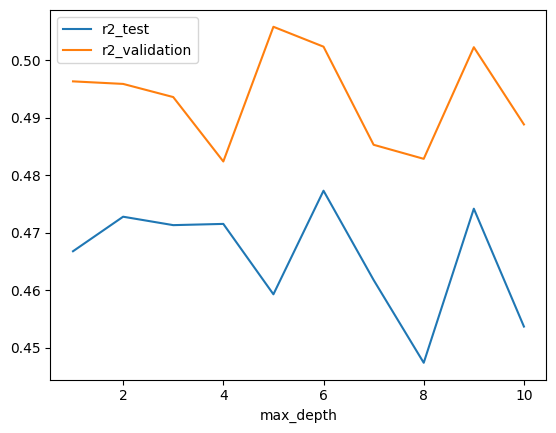

In [99]:
metrics = []
for max_depth in range(1, 11):
	ensemble = Ensemble(X_train, y_train, n_trees=100, max_depth=7)
	ensemble_predictions = ensemble.predict_ensemble(X_test)
	metrics.append({
		"r2_test": r2_score(y_test, ensemble.predict_ensemble(X_test)),
		"r2_validation": r2_score(y_validation, ensemble.predict_ensemble(X_validation)),
		"max_depth": max_depth
	})
df_metrics = pd.DataFrame(metrics)
df_metrics
df_metrics.plot(y=["r2_test", "r2_validation"], x="max_depth")